# <span style="color:blue">Controle de Ventilador</span>

#### Este notebook é destinado a demonstrar  como determinar a velocidade de um ventilador com base na temperatura e da umidade na localidade do computador que pocessa os scripts 

#### O sistema obtém a temperatura e a umidade a partir da longitude e da latitude do computador. Com isso, através da Lógica Fuzzy, a velocidade do ventilador será definida para o clima obtido na internet.


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Importação das bibliotecas</h2>
</div>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import skfuzzy as fuzz
import requests
import geocoder
import warnings

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Condições Iniciais</h2>
</div>

In [29]:
%matplotlib inline

warnings.filterwarnings('ignore')

path_saida = 'saida/'

plot_fuzzy_set = False

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Configuração dos Antecedentes</h2>
</div>

In [30]:
# Definições de funções de pertinência de três faixas diferentes de temperaturas.
temperatura = ctrl.Antecedent(np.arange(6, 51.5, 0.5), 'F_TEMP')
temperatura['Baixa'] = fuzz.gaussmf(temperatura.universe, mean=6, sigma=5.0)
temperatura['Media'] = fuzz.gaussmf(temperatura.universe, mean=25, sigma=1.5)
temperatura['Alta'] = fuzz.gaussmf(temperatura.universe, mean=51, sigma=7.0)
if plot_fuzzy_set:
    temperatura.view()
    plt.title('Temperatura')
    plt.savefig(path_saida+'temperatura-Atencedente')

In [31]:
# Definições de funções de adesão de três faixas diferentes de umidade.
umidade = ctrl.Antecedent(np.arange(11, 93.5, 0.5), 'F_UMID')
umidade['Baixa'] = fuzz.gaussmf(umidade.universe, mean=11, sigma=8)
umidade['Media'] = fuzz.gaussmf(umidade.universe, mean=50, sigma=8)
umidade['Alta'] = fuzz.gaussmf(umidade.universe, mean=93, sigma=8)
if plot_fuzzy_set:
    umidade.view()
    plt.title('Umidade')
    plt.savefig(path_saida+'umidade-Atencedente')

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Configeração dos Consequentes</h2>
</div>

In [32]:
velocidade = ctrl.Consequent(np.arange(0, 4.02, 0.02), 'F_VELOC')
velocidade['Parado'] = fuzz.trapmf(velocidade.universe, [0, 0, 0.3, 0.5])
velocidade['Baixa'] = fuzz.trapmf(velocidade.universe, [0.3, 0.5, 0.8, 1])
velocidade['Media'] = fuzz.trapmf(velocidade.universe, [0.8, 1.1, 1.6, 2.0])
velocidade['Alta'] = fuzz.trapmf(velocidade.universe, [1.8, 2.3, 2.8, 3.2])
velocidade['Muito_Alta'] = fuzz.trapmf(velocidade.universe, [3.0, 3.5, 4.0, 4.0])
if plot_fuzzy_set:
    velocidade.view()
    plt.title('Velocidade')
    plt.savefig(path_saida + 'velocidade-Consequente')

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Definação das Regras</h2>
</div>

In [33]:
# Regra 1: Temperatura Baixa -> Ventilador Parado.
regra1 = ctrl.Rule(temperatura['Baixa'], velocidade['Parado'])

# Regra 2: Temperatura Média e Umidade Baixa -> Velocidade Baixa.
regra2 = ctrl.Rule(temperatura['Media'] & umidade['Baixa'], velocidade['Baixa'])

# Regra 3: Temperatura Média e Umidade Média  -> Velocidade Média.
regra3 = ctrl.Rule(temperatura['Media'] & umidade['Media'], velocidade['Media'])

# Regra 4: Temperatura Média   e Umidade Alta -> Velocidade Alta.
regra4 = ctrl.Rule(temperatura['Media'] & umidade['Alta'], velocidade['Alta'])

# Regra 5: Temperatura Alta e Umidade Baixa -> Velocidade Média.
regra5 = ctrl.Rule(temperatura['Alta'] & umidade['Baixa'], velocidade['Media'])

# Regra 6: Temperatura Alta e Umidade Média -> Velocidade Alta
regra6 = ctrl.Rule(temperatura['Alta'] & umidade['Media'], velocidade['Alta'])

# Regra 7: Temperatura Alta e Umidade Alta -> Velocidade Muito Alto.
regra7 = ctrl.Rule(temperatura['Alta'] & umidade['Alta'], velocidade['Muito_Alta'])

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Configuração do Controle de Sistema</h2>
</div>

In [34]:
velocidade_ventilador_ctrl = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5, regra6, regra7])
velocidade_ventilador = ctrl.ControlSystemSimulation(velocidade_ventilador_ctrl)

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Funções de Apoio</h2>
</div>

In [35]:
def obtem_velocidade(ponto_temperatura, ponto_umidade):
    # Estima a velocidade em relação a tempertatura e a umidade.
    velocidade_ventilador.input['F_TEMP'] = ponto_temperatura
    velocidade_ventilador.input['F_UMID'] = ponto_umidade
    velocidade_ventilador.compute()
    return velocidade_ventilador.output['F_VELOC']


In [36]:
def plot_result(ponto_temperatura, ponto_umidade, velocidade_estimada):
    # Mostra o resultado gráfico de resultado da velocidade em relação a tempertatura e a umidade.
    velocidade.view(sim=velocidade_ventilador)
    plt.suptitle(f'Temperatura:{round(ponto_temperatura, 2)} - Umidade:{round(ponto_umidade, 2)} - Velocidade:{round(velocidade_estimada, 2)}')
    plt.xlabel('Velocidade')
    plt.show()
    return


In [37]:
def obtem_localidade():
    # Obtém a localização atual com base no endereço IP
    current_location = geocoder.ip('me')

    # Verifica o sucesso da obtenção da localidade.
    if current_location.ok:
        latitude, longitude = current_location.latlng
    else:
        latitude, longitude = None, None
    return latitude, longitude

In [38]:
def obtem_clima(api_key='e16e38f2fb8b2907d934a32850d99cfc', latitude=None, longitude=None):
    base_url = "http://api.openweathermap.org/data/2.5/weather"

    # Make a GET request to the OpenWeatherMap API
    response = requests.get(base_url, params={"lat": latitude, "lon": longitude, "appid": api_key, "units": "metric"})

    if response.status_code == 200:
        weather_data = response.json()

        # Extract temperature and humidity from the response
        temperature = weather_data["main"]["temp"]
        humidity = weather_data["main"]["humidity"]
        message_erro = None
    else:
        temperature, humidity = None, None
        message_erro = f"Failed to retrieve weather data. Status code: {response.status_code}"
    return temperature, humidity, message_erro


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Obtém a Velocidade do Ventilador</h2>
</div>

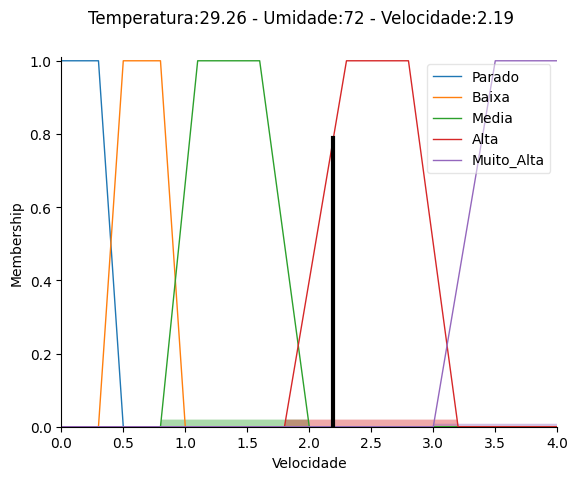

In [39]:
latitude, longitude = obtem_localidade()
ponto_temperatura_atual, ponto_umidade_atual, message_erro = obtem_clima(latitude=latitude, longitude=longitude)
if message_erro ==  None:
    velocidade_estimada = obtem_velocidade(ponto_temperatura_atual, ponto_umidade_atual)
    plot_result(ponto_temperatura_atual, ponto_umidade_atual, velocidade_estimada)
else:
    print(message_erro)